 This script is used to produce Suplementary Figures of the manuscript
'Plasmid-mediated phenotypic noise leads to transient antibiotic resistance in bacteria'.

MIT License

Copyright (c) 2023 JCRHB/RPM


## Supplementary Figure 2



## System preparation


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
import scipy.stats as stats
import random


### Mounting Gdrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### File paths

In [3]:
rootDir="/content/drive/MyDrive/SYNC_Projects/"
rootDir=rootDir+"pBGT/GIT/"

workingDir=rootDir+"code/Supplementary/"
data_path=rootDir+"data/supplementary/sFig-2/"
qpcr_raw_data_path=data_path+"qPCR/"
#amnis_raw_data_path=data_path+"AMNIS/"
#synergy_raw_data_path=data_path+"Synergy/"
sfig_path=rootDir+"figures/SuppFigures/"


## qPCRs

### Setup primers efficiency


In [4]:
eff_dxs1=1.1673  #using 8-fold
eff_dxs=1.0439  #using 8-fold and discarting more diluted reaction

eff_tem=1.2317
eff_tem=1.0647  #using 8-fold


### G54U

#### Amplification Overview

In [5]:

G54_file_ampli=qpcr_raw_data_path+"G54U/G54U_4repsbio_3repstech -  Quantification Amplification Results_SYBR.csv"
G54_df_ampli=pd.read_csv(G54_file_ampli)
G54_df_ampli.head()

,Unnamed: 0,Cycle,A1,A2,A3,A4,A5,A6,A7,A8,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,NaN,1,-7.987968,-21.583157,-12.598373,-8.523945,-2.137198,-6.500291,-18.669900,0.287648,...,-2.069761,22.859104,28.966603,29.382650,-1.898650,6.142356,-1.715186,-4.479003,-4.042176,-14.468794
1,NaN,2,1.328584,-6.885942,-5.209806,0.520445,-0.548097,-1.038352,-8.036682,0.879188,...,4.408350,37.316389,46.892750,44.102569,2.414817,14.884676,9.218385,5.743156,2.938378,-0.550169
2,NaN,3,2.377908,0.516546,0.326181,0.338275,1.778426,8.312857,1.584531,4.925446,...,5.945194,47.317682,54.633735,51.436070,3.981482,7.870442,3.381447,3.176984,0.375846,2.341015
3,NaN,4,4.399001,-1.819625,0.394415,3.231624,2.093131,0.303423,-2.120778,0.455742,...,4.156808,57.686467,63.295767,53.736370,2.973265,5.348779,6.324324,-0.860375,-0.806214,3.444485
4,NaN,5,2.229174,3.230621,4.444828,2.602221,3.643215,0.047898,1.310621,-1.253017,...,2.960018,66.847917,82.141741,71.190166,4.224136,1.882415,3.129329,7.022467,5.122343,-0.063617


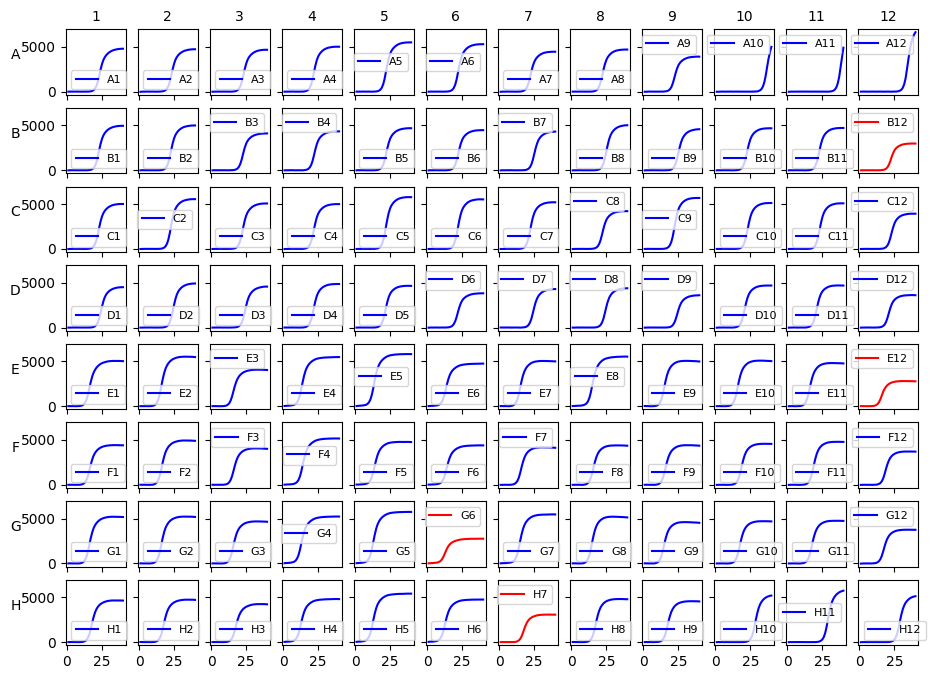

In [6]:
cols=[x for x in np.arange(1,13)]
rows="A B C D E F G H"
rows=rows.split()
fig,axs=plt.subplots(len(rows),len(cols),sharex=True,sharey=True,figsize=(11,8))
time=G54_df_ampli["Cycle"]
G54_exclude_wells=[]
for ri,row in enumerate(rows):
    for ci,col in enumerate(cols):
        well=row+str(col)
        vals=list(G54_df_ampli[well])
        color='b'
        if(vals[-1]<3100):
            color='r'
            G54_exclude_wells.append(well)
        axs[ri,ci].plot(time,vals,c=color,label=well)
        axs[ri,ci].legend(fontsize=8)

for ax, col in zip(axs[0], cols):
    ax.set_title(col,size=10)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size=10)

plt.show()

#### Select wells to exclude from analysis

In [7]:
G54_ex_wells=[]
print(G54_exclude_wells)
for x in G54_exclude_wells:
    st=[y for y in x]
    #print(st)
    if(len(x)<3):
        st=st[0]+"0"+st[1]
    else:
        st=st[0]+st[1]+st[2]
    G54_ex_wells.append(st)
G54_ex_wells


['B12', 'E12', 'G6', 'H7']


['B12', 'E12', 'G06', 'H07']

#### Read Ct file

In [8]:
G54_file=qpcr_raw_data_path+"G54U/G54U_4repsbio_3repstech -  Quantification Cq Results.csv"
G54_df_all=pd.read_csv(G54_file)
G54_df_all.head()


,Unnamed: 0,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Set Point,Well Note
0,NaN,A01,SYBR,dxs,Std,lb-1,rep1,21.466125,21.466125,0,1000000.0,6.0,1000000.0,0,60,NaN
1,NaN,A02,SYBR,dxs,Std,lb-1,rep1,21.432083,21.432083,0,1000000.0,6.0,1000000.0,0,60,NaN
2,NaN,A03,SYBR,dxs,Std,lb-1,rep1,21.413878,21.413878,0,1000000.0,6.0,1000000.0,0,60,NaN
3,NaN,A04,SYBR,dxs,Std,amp-2,rep1,20.073895,20.073895,0,1000000.0,6.0,1000000.0,0,60,NaN
4,NaN,A05,SYBR,dxs,Std,amp-2,rep1,20.046059,20.046059,0,1000000.0,6.0,1000000.0,0,60,NaN


In [9]:
primers=["dxs","tem"]
G54_day1_repsT=["01","02","03"]
G54_day2_repsT=["04","05","06"]
G54_day3_repsT=["07","08","09"]
G54_days=[G54_day1_repsT,G54_day2_repsT,G54_day3_repsT]
G54_repsB_dxs=["A","B","C","D"]
G54_repsB_tem=["E","F","G","H"]

G54_control_repsT=["10","11","12"]
G54_control_days_dxs=["B","C","D"]
G54_control_days_tem=["E","F","G"]



xxxxx C06 G06
xxxxx D07 H07


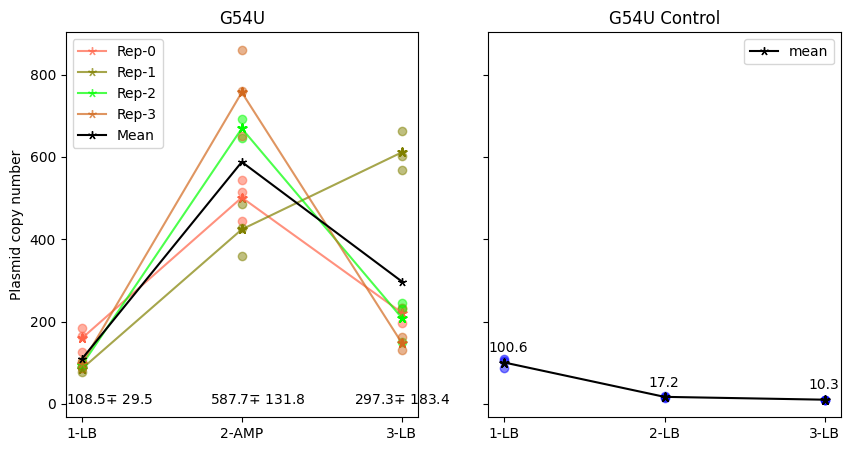

In [10]:

fig,ax=plt.subplots(1,2,figsize=(10,5),sharey=True)
col_mean=[]
for row in range(0,len(G54_control_days_dxs)):
    row_mean_d=[]
    row_mean_t=[]
    row_mean_cn=[]
    for ci,col in enumerate(G54_control_repsT):
        well_d=G54_control_days_dxs[row]+str(col)
        well_t=G54_control_days_tem[row]+str(col)
        ct_d=list(G54_df_all[G54_df_all["Well"]==well_d]["Cq"])[0]
        ct_t=list(G54_df_all[G54_df_all["Well"]==well_t]["Cq"])[0]
        cn_eff=((1+eff_dxs)**ct_d)/((1+eff_tem)**ct_t)
        if(np.isnan(cn_eff)):
            continue
        row_mean_d.append(ct_d)
        row_mean_t.append(ct_t)
        row_mean_cn.append(cn_eff)
        ax[1].scatter(row+1,cn_eff,c='b',alpha=.5)
    mean_d=np.mean(row_mean_d)
    mean_t=np.mean(row_mean_t)
    mean_cn=np.mean(row_mean_cn)
    col_mean.append(mean_cn)
    ax[1].scatter(row+1,mean_cn,c='k',marker=(5, 2))

ax[1].plot([1,2,3],col_mean,c='k',marker=(5, 2),label="mean")
for x in range(1,4):
    m=round(col_mean[x-1],1)

    ax[1].text(x-.1,m+25,'%s'%(m))


clrs=["tomato", "olive","lime","chocolate"]

normv=1

all_means=[]
for ri in range(0,len(G54_repsB_dxs)):
    bio_mean_cn=[]
    for di,day in enumerate(G54_days):
        tech_mean_d=[]
        tech_mean_t=[]
        tech_mean_cn=[]
        for ci,col in enumerate(day):
            well_d=G54_repsB_dxs[ri]+col
            well_t=G54_repsB_tem[ri]+col
            ct_d=list(G54_df_all[G54_df_all["Well"]==well_d]["Cq"])[0]
            ct_t=list(G54_df_all[G54_df_all["Well"]==well_t]["Cq"])[0]
            cn_eff=((1+eff_dxs)**ct_d)/((1+eff_tem)**ct_t)
            #normv=col_mean[0]
            cn_eff=cn_eff/normv

            if(np.isnan(cn_eff)):
                print("xxx",well_d, well_t)
                continue
            if(well_d in G54_ex_wells or well_t in G54_ex_wells):
                print("xxxxx",well_d, well_t)
                continue
            tech_mean_d.append(ct_d)
            tech_mean_t.append(ct_t)
            tech_mean_cn.append(cn_eff)
            #print(well_d,round(ct_d,1),round(ct_t,1),"->",cn_eff,end="\t")
            ax[0].scatter(di+1,cn_eff,c=clrs[ri],alpha=.5)
        mean_d=np.mean(tech_mean_d)
        mean_t=np.mean(tech_mean_t)

        mean_cn=np.mean(tech_mean_cn)
        ax[0].scatter(di+1,mean_cn,c=clrs[ri],marker=(5, 2))
        bio_mean_cn.append(mean_cn)

    all_means.append(bio_mean_cn)
    ax[0].plot([1,2,3],bio_mean_cn,c=clrs[ri],alpha=.7,marker=(5, 2),label="Rep-%s"%ri)
y1=[x[0] for x in all_means]
y2=[x[1] for x in all_means]
y3=[x[2] for x in all_means]
ys=[y1,y2,y3]
means=[np.mean(y) for y in ys]
stds=[np.std(y) for y in ys]

ax[0].plot([1,2,3],means,c='k',marker=(5, 2),label="Mean")
xs=["1-LB","2-AMP","3-LB"]
ax[0].legend()
ax[0].set_xticks([1,2,3])
ax[0].set_xticklabels(xs)
ax[0].set_ylabel("Plasmid copy number")
ax[0].set_title("G54U")
for x in range(1,4):
    m=round(means[x-1],1)
    s=round(stds[x-1],1)
    ax[0].text(x-(.1*x),0,r'%s$\mp$ %s'%(m,s))

xs=["1-LB","2-LB","3-LB"]
ax[1].legend()
ax[1].set_xticks([1,2,3])
ax[1].set_xticklabels(xs)
ax[1].set_title("G54U Control")
#ax[1].set_yscale("log")
plt.show()



### G55U

#### Amplification Overview

In [11]:
G55_file_ampli=qpcr_raw_data_path+"G55U/G55U_4repsbio_3repstech -  Quantification Amplification Results_SYBR.csv"
G55_df_ampli=pd.read_csv(G55_file_ampli)
G55_df_ampli.head()

,Unnamed: 0,Cycle,A1,A2,A3,A4,A5,A6,A7,A8,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,NaN,1,-5.974423,3.887024,-0.809522,2.004167,0.009848,-15.941656,6.122522,0.100395,...,12.103047,9.166837,19.688870,8.244609,27.417988,12.208384,1.969707,-4.891869,-12.069407,-14.306238
1,NaN,2,6.836864,2.899426,5.776762,7.272473,4.440015,-6.640786,10.849384,11.538617,...,13.177826,29.365455,35.564633,30.967392,22.750256,16.864332,10.887490,8.118104,-6.932390,-6.283152
2,NaN,3,0.039892,1.608720,3.546169,3.590779,6.596491,1.359380,6.205819,8.230602,...,8.406397,40.181957,40.401040,38.157015,14.153770,4.303040,10.579706,13.086438,-3.542605,1.110292
3,NaN,4,1.417979,6.812412,3.154990,7.165312,8.083372,2.487218,6.858828,3.676014,...,5.711175,50.723424,47.629234,54.493729,7.555711,10.589437,5.829614,15.295560,2.568626,3.405673
4,NaN,5,4.147984,5.548033,2.763558,2.471095,0.172926,5.282717,2.477156,3.732469,...,-1.808043,58.173939,56.355356,59.434233,2.992591,2.917698,7.979145,19.119450,4.853978,6.973980


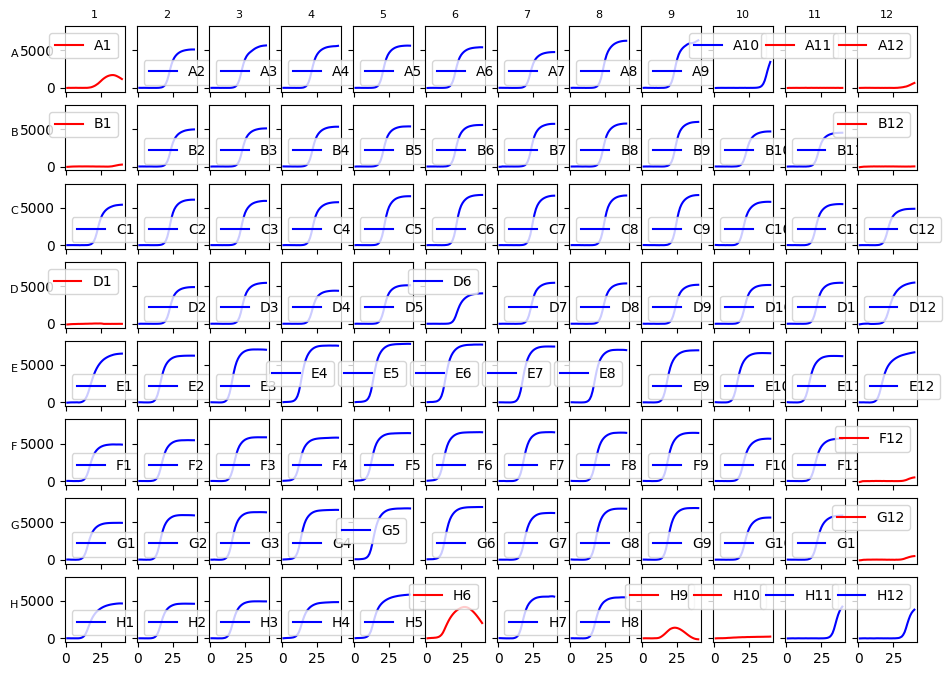

In [12]:
cols=[x for x in np.arange(1,13)]
rows="A B C D E F G H"
rows=rows.split()
fig,axs=plt.subplots(len(rows),len(cols),sharex=True,sharey=True,figsize=(11,8))
time=G55_df_ampli["Cycle"]
G55_exclude_wells=[]
for ri,row in enumerate(rows):
    for ci,col in enumerate(cols):
        well=row+str(col)
        vals=list(G55_df_ampli[well])
        color='b'
        if(vals[-1]<3100):
            color='r'
            G55_exclude_wells.append(well)
        axs[ri,ci].plot(time,vals,c=color,label=well)
        axs[ri,ci].legend(fontsize=10)

for ax, col in zip(axs[0], cols):
    ax.set_title(col,size=8)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size=8)

plt.show()

#### Select wells to exclude from analysis

In [13]:
G55_ex_wells=[]
print(G55_exclude_wells)
for x in G55_exclude_wells:
    st=[y for y in x]
    #print(st)
    if(len(x)<3):
        st=st[0]+"0"+st[1]
    else:
        st=st[0]+st[1]+st[2]
    G55_ex_wells.append(st)
G55_ex_wells


['A1', 'A11', 'A12', 'B1', 'B12', 'D1', 'F12', 'G12', 'H6', 'H9', 'H10']


['A01', 'A11', 'A12', 'B01', 'B12', 'D01', 'F12', 'G12', 'H06', 'H09', 'H10']

#### Read Ct file

In [14]:
G55_file=qpcr_raw_data_path+"G55U/G55U_4repsbio_3repstech -  Quantification Cq Results.csv"
G55_df_all=pd.read_csv(G55_file)
G55_df_all.head()


,Unnamed: 0,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Set Point,Well Note
0,NaN,A01,SYBR,dxs,Std,lb-1,rep1,25.087018,25.087018,0,1000000.0,6.0,1000000.0,0,60,NaN
1,NaN,A02,SYBR,dxs,Std,lb-1,rep1,20.725992,20.725992,0,1000000.0,6.0,1000000.0,0,60,NaN
2,NaN,A03,SYBR,dxs,Std,lb-1,rep1,20.664188,20.664188,0,1000000.0,6.0,1000000.0,0,60,NaN
3,NaN,A04,SYBR,dxs,Std,amp-2,rep1,19.287279,19.287279,0,1000000.0,6.0,1000000.0,0,60,NaN
4,NaN,A05,SYBR,dxs,Std,amp-2,rep1,18.890160,18.890160,0,1000000.0,6.0,1000000.0,0,60,NaN


In [15]:
primers=["dxs","tem"]
G55_day1_repsT=["01","02","03"]
G55_day2_repsT=["04","05","06"]
G55_day3_repsT=["07","08","09"]
G55_days=[G55_day1_repsT,G55_day2_repsT,G55_day3_repsT]
G55_repsB_dxs=["A","B","C","D"]
G55_repsB_tem=["E","F","G","H"]

G55_control_repsT=["10","11","12"]
G55_control_days_dxs=["B","C","D"]
G55_control_days_tem=["E","F","G"]



xxxxx A01 E01
xxx B01 F01
xxx D01 H01
xxxxx D06 H06
xxxxx D09 H09


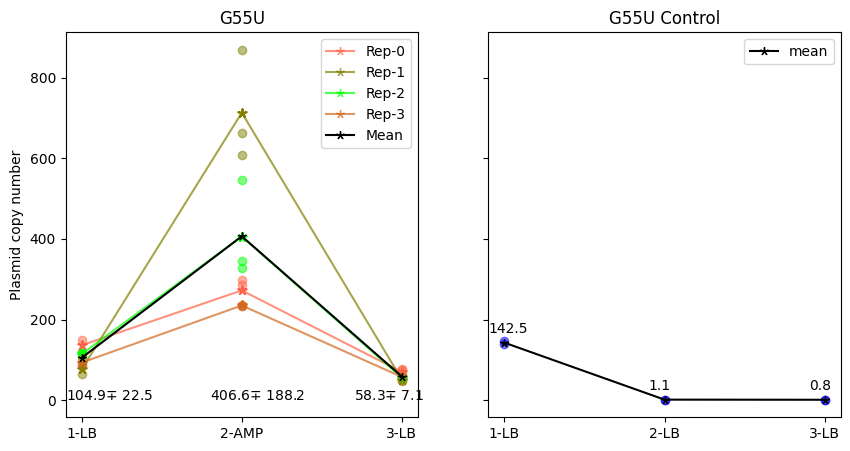

In [16]:
fig,ax=plt.subplots(1,2,figsize=(10,5),sharey=True)
col_mean=[]
for row in range(0,len(G55_control_days_dxs)):
    row_mean_d=[]
    row_mean_t=[]
    row_mean_cn=[]
    for ci,col in enumerate(G55_control_repsT):
        well_d=G55_control_days_dxs[row]+str(col)
        well_t=G55_control_days_tem[row]+str(col)
        ct_d=list(G55_df_all[G55_df_all["Well"]==well_d]["Cq"])[0]
        ct_t=list(G55_df_all[G55_df_all["Well"]==well_t]["Cq"])[0]
        cn_eff=((1+eff_dxs)**ct_d)/((1+eff_tem)**ct_t)
        if(np.isnan(cn_eff)):
            continue
        row_mean_d.append(ct_d)
        row_mean_t.append(ct_t)
        row_mean_cn.append(cn_eff)
        ax[1].scatter(row+1,cn_eff,c='b',alpha=.5)
    mean_d=np.mean(row_mean_d)
    mean_t=np.mean(row_mean_t)
    mean_cn=np.mean(row_mean_cn)
    col_mean.append(mean_cn)
    #ax[1].scatter(row+1,mean_cn,c='k',marker=(5, 2))

ax[1].plot([1,2,3],col_mean,c='k',marker=(5, 2),label="mean")
for x in range(1,4):
    m=round(col_mean[x-1],1)

    ax[1].text(x-.1,m+25,'%s'%(m))


clrs=["tomato", "olive","lime","chocolate"]

normv=1

all_means=[]
for ri in range(0,len(G55_repsB_dxs)):
    bio_mean_cn=[]
    for di,day in enumerate(G55_days):
        tech_mean_d=[]
        tech_mean_t=[]
        tech_mean_cn=[]
        for ci,col in enumerate(day):
            well_d=G55_repsB_dxs[ri]+col
            well_t=G55_repsB_tem[ri]+col
            ct_d=list(G55_df_all[G55_df_all["Well"]==well_d]["Cq"])[0]
            ct_t=list(G55_df_all[G55_df_all["Well"]==well_t]["Cq"])[0]
            cn_eff=((1+eff_dxs)**ct_d)/((1+eff_tem)**ct_t)
            #normv=col_mean[0]
            cn_eff=cn_eff/normv

            if(np.isnan(cn_eff)):
                print("xxx",well_d, well_t)
                continue
            if(well_d in G55_ex_wells or well_t in G55_ex_wells):
                print("xxxxx",well_d, well_t)
                continue
            tech_mean_d.append(ct_d)
            tech_mean_t.append(ct_t)
            tech_mean_cn.append(cn_eff)
            #print(well_d,round(ct_d,1),round(ct_t,1),"->",cn_eff,end="\t")
            ax[0].scatter(di+1,cn_eff,c=clrs[ri],alpha=.5)
        mean_d=np.mean(tech_mean_d)
        mean_t=np.mean(tech_mean_t)

        mean_cn=np.mean(tech_mean_cn)
        ax[0].scatter(di+1,mean_cn,c=clrs[ri],marker=(5, 2))
        bio_mean_cn.append(mean_cn)

    all_means.append(bio_mean_cn)
    ax[0].plot([1,2,3],bio_mean_cn,c=clrs[ri],alpha=.7,marker=(5, 2),label="Rep-%s"%ri)
y1=[x[0] for x in all_means]
y2=[x[1] for x in all_means]
y3=[x[2] for x in all_means]
ys=[y1,y2,y3]
means=[np.mean(y) for y in ys]
stds=[np.std(y) for y in ys]


ax[0].plot([1,2,3],means,c='k',marker=(5, 2),label="Mean")
xs=["1-LB","2-AMP","3-LB"]
ax[0].legend()
ax[0].set_xticks([1,2,3])
ax[0].set_xticklabels(xs)
ax[0].set_ylabel("Plasmid copy number")
ax[0].set_title("G55U")
for x in range(1,4):
    m=round(means[x-1],1)
    s=round(stds[x-1],1)
    ax[0].text(x-(.1*x),0,r'%s$\mp$ %s'%(m,s))

xs=["1-LB","2-LB","3-LB"]
ax[1].legend()
ax[1].set_xticks([1,2,3])
ax[1].set_xticklabels(xs)
ax[1].set_title("G55U Control")
#ax[1].set_yscale("log")
plt.show()



# Plotting Figure S3

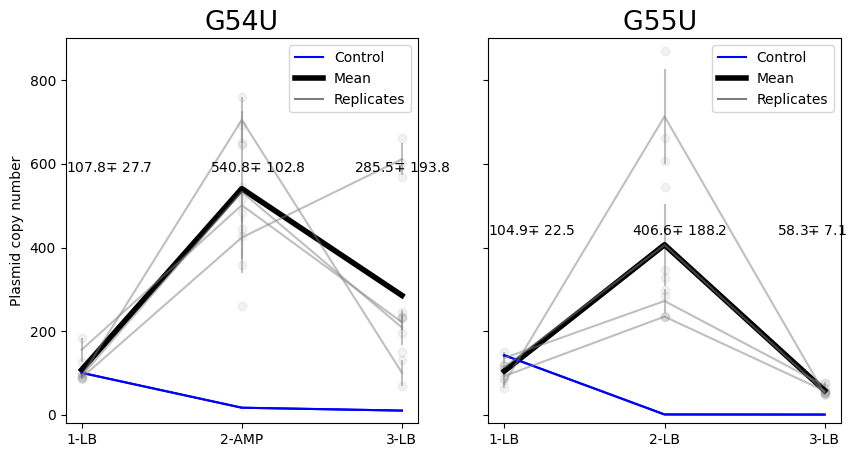

In [17]:

fig,ax=plt.subplots(1,2,figsize=(10,5),sharey=True)
fig.set_facecolor('white')
plt.rcParams.update({'font.size': 16})


col_mean=[]
col_std=[]
for row in range(0,len(G54_control_days_dxs)):
    row_mean_d=[]
    row_mean_t=[]
    row_mean_cn=[]
    for ci,col in enumerate(G54_control_repsT):
        well_d=G54_control_days_dxs[row]+str(col)
        well_t=G54_control_days_tem[row]+str(col)
        ct_d=list(G54_df_all[G54_df_all["Well"]==well_d]["Cq"])[0]
        ct_t=list(G54_df_all[G54_df_all["Well"]==well_t]["Cq"])[0]
        cn_eff=((1+eff_dxs)**ct_d)/((1+eff_tem)**ct_t)
        if(np.isnan(cn_eff)):
            continue
        row_mean_d.append(ct_d)
        row_mean_t.append(ct_t)
        row_mean_cn.append(cn_eff)

    mean_d=np.mean(row_mean_d)
    mean_t=np.mean(row_mean_t)
    mean_cn=np.mean(row_mean_cn)
    col_mean.append(mean_cn)
    std_cn=np.std(row_mean_cn)
    col_std.append(std_cn)

ax[0].plot([1,2,3],col_mean,c='blue',label="Control")
ax[0].errorbar([1,2,3],col_mean,yerr=col_std,c='blue')
# for x in range(1,4):
#     m=round(col_mean[x-1],1)
#     ax[1].text(x-.1,m+25,'%s'%(m))

normv=1

all_means=[]
for ri in range(0,len(G54_repsB_dxs)):
    bio_mean_cn=[]
    bio_std_cn=[]
    for di,day in enumerate(G54_days):
        tech_mean_d=[]
        tech_mean_t=[]
        tech_mean_cn=[]
        for ci,col in enumerate(day):
            well_d=G55_repsB_dxs[ri]+col
            well_t=G55_repsB_tem[ri]+col
            ct_d=list(G54_df_all[G54_df_all["Well"]==well_d]["Cq"])[0]
            ct_t=list(G54_df_all[G54_df_all["Well"]==well_t]["Cq"])[0]
            cn_eff=((1+eff_dxs)**ct_d)/((1+eff_tem)**ct_t)
            #normv=col_mean[0]
            cn_eff=cn_eff/normv

            if(np.isnan(cn_eff)):
                #print("xxx",well_d, well_t)
                continue
            if(well_d in G55_ex_wells or well_t in G55_ex_wells):
                #print("xxxxx",well_d, well_t)
                continue
            tech_mean_d.append(ct_d)
            tech_mean_t.append(ct_t)
            tech_mean_cn.append(cn_eff)
            ax[0].scatter(di+1,cn_eff,c="gray",alpha=.1)
        mean_d=np.mean(tech_mean_d)
        mean_t=np.mean(tech_mean_t)

        mean_cn=np.mean(tech_mean_cn)
        std_cn=np.std(tech_mean_cn)
        bio_mean_cn.append(mean_cn)
        bio_std_cn.append(std_cn)

    all_means.append(bio_mean_cn)
    ax[0].errorbar([1,2,3],bio_mean_cn,yerr=bio_std_cn,c="gray",alpha=.5)#,marker=(5, 2),label="Rep-%s"%ri)
y1=[x[0] for x in all_means]
y2=[x[1] for x in all_means]
y3=[x[2] for x in all_means]
ys=[y1,y2,y3]
means=[np.mean(y) for y in ys]
stds=[np.std(y) for y in ys]
ax[0].plot([1,2,3],means,c='k',lw=4,label="Mean")


ax[0].set_title("G55U")
for x in range(1,4):
    m=round(means[x-1],1)
    s=round(stds[x-1],1)
    ax[0].text(x-(.1*x),580,r'%s$\mp$ %s'%(m,s),fontsize=10)


################################# G55

col_mean=[]
col_std=[]

for row in range(0,len(G55_control_days_dxs)):
    row_mean_d=[]
    row_mean_t=[]
    row_mean_cn=[]
    for ci,col in enumerate(G55_control_repsT):
        well_d=G55_control_days_dxs[row]+str(col)
        well_t=G55_control_days_tem[row]+str(col)
        ct_d=list(G55_df_all[G55_df_all["Well"]==well_d]["Cq"])[0]
        ct_t=list(G55_df_all[G55_df_all["Well"]==well_t]["Cq"])[0]
        cn_eff=((1+eff_dxs)**ct_d)/((1+eff_tem)**ct_t)


        if(np.isnan(cn_eff)):
            continue
        row_mean_d.append(ct_d)
        row_mean_t.append(ct_t)
        row_mean_cn.append(cn_eff)

    mean_d=np.mean(row_mean_d)
    mean_t=np.mean(row_mean_t)
    mean_cn=np.mean(row_mean_cn)
    col_mean.append(mean_cn)
    std_cn=np.std(row_mean_cn)
    col_std.append(std_cn)

ax[1].plot([1,2,3],col_mean,c='blue',label="Control")
ax[1].errorbar([1,2,3],col_mean,yerr=col_std,c='blue')
# # for x in range(1,4):
# #     m=round(col_mean[x-1],1)
# #     ax[1].text(x-.1,m+25,'%s'%(m))

# normv=1

all_means=[]
for ri in range(0,len(G55_repsB_dxs)):
    bio_mean_cn=[]
    bio_std_cn=[]
    for di,day in enumerate(G55_days):
        tech_mean_d=[]
        tech_mean_t=[]
        tech_mean_cn=[]
        for ci,col in enumerate(day):
            well_d=G55_repsB_dxs[ri]+col
            well_t=G55_repsB_tem[ri]+col
            ct_d=list(G55_df_all[G55_df_all["Well"]==well_d]["Cq"])[0]
            ct_t=list(G55_df_all[G55_df_all["Well"]==well_t]["Cq"])[0]
            cn_eff=((1+eff_dxs)**ct_d)/((1+eff_tem)**ct_t)
            #normv=col_mean[0]
            cn_eff=cn_eff/normv

            if(np.isnan(cn_eff)):
                #print("xxx",well_d, well_t)
                continue
            if(well_d in G55_ex_wells or well_t in G55_ex_wells):
                #print("xxxxx",well_d, well_t)
                continue
            tech_mean_d.append(ct_d)
            tech_mean_t.append(ct_t)
            tech_mean_cn.append(cn_eff)
            ax[1].scatter(di+1,cn_eff,c="gray",alpha=.1)
        mean_d=np.mean(tech_mean_d)
        mean_t=np.mean(tech_mean_t)

        mean_cn=np.mean(tech_mean_cn)
        std_cn=np.std(tech_mean_cn)
        bio_mean_cn.append(mean_cn)
        bio_std_cn.append(std_cn)

    all_means.append(bio_mean_cn)
    ax[1].errorbar([1,2,3],bio_mean_cn,yerr=bio_std_cn,c="gray",alpha=.5)#,marker=(5, 2),label="Rep-%s"%ri)
y1=[x[0] for x in all_means]
y2=[x[1] for x in all_means]
y3=[x[2] for x in all_means]
ys=[y1,y2,y3]
means=[np.mean(y) for y in ys]
stds=[np.std(y) for y in ys]
ax[1].plot([1,2,3],means,c='k',lw=4,label="Mean")






ax[0].plot([1,2,3],[-100,-100,-100],c='gray',label="Replicates")
ax[1].plot([1,2,3],[-100,-100,-100],c='gray',label="Replicates")
ax[0].set_ylim([-20,900])

ax[1].set_xticks([1,2,3])
ax[1].set_xticklabels(xs)
ax[1].set_title("G55U ")


xs=["1-LB","2-AMP","3-LB"]
ax[0].set_xticks([1,2,3])
ax[0].set_xticklabels(xs)
ax[0].set_ylabel("Plasmid copy number")
ax[0].set_title("G54U")
for x in range(1,4):
    m=round(means[x-1],1)
    s=round(stds[x-1],1)
    ax[1].text(x-(.1*x),430,r'%s$\mp$ %s'%(m,s),fontsize=10)

ax[0].legend(fontsize=10)
ax[1].legend(fontsize=10)

#ax[1].set_yscale("log")


#print("Saving fig as: \n",out_fig_name)
#plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)

plt.show()



 ## Plotting both strains PCN fold change

Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/SuppFigures/sFig-2.pdf


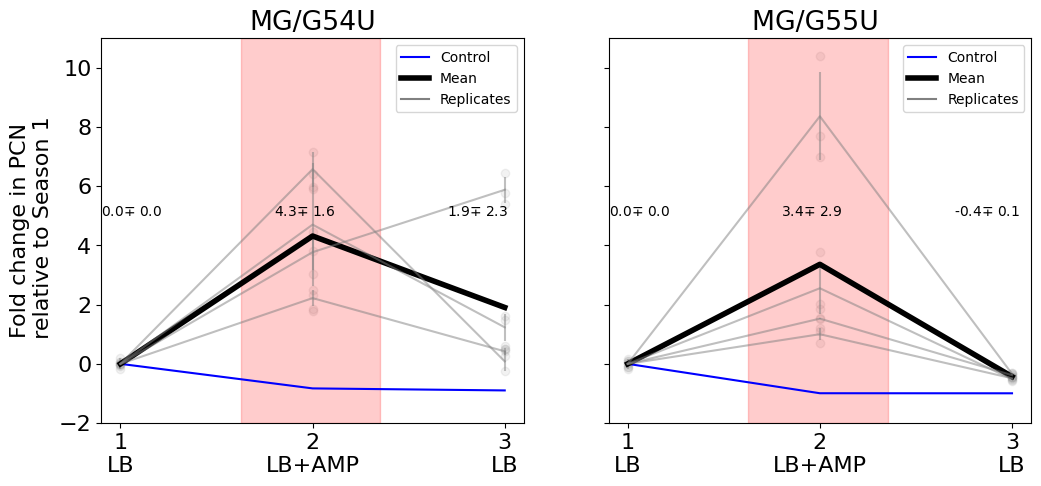

In [18]:
fig,ax=plt.subplots(1,2,figsize=(12,5),sharey=True)
fig.set_facecolor('white')
plt.rcParams.update({'font.size': 16})

col_mean=[]
col_std=[]
for row in range(0,len(G54_control_days_dxs)):
    row_mean_d=[]
    row_mean_t=[]
    row_mean_cn=[]
    for ci,col in enumerate(G54_control_repsT):
        well_d=G54_control_days_dxs[row]+str(col)
        well_t=G54_control_days_tem[row]+str(col)
        ct_d=list(G54_df_all[G54_df_all["Well"]==well_d]["Cq"])[0]
        ct_t=list(G54_df_all[G54_df_all["Well"]==well_t]["Cq"])[0]
        cn_eff=((1+eff_dxs)**ct_d)/((1+eff_tem)**ct_t)
        if(np.isnan(cn_eff)):
            continue
        row_mean_d.append(ct_d)
        row_mean_t.append(ct_t)
        row_mean_cn.append(cn_eff)

    mean_d=np.mean(row_mean_d)
    mean_t=np.mean(row_mean_t)
    mean_cn=np.mean(row_mean_cn)
    col_mean.append(mean_cn)
    std_cn=np.std(row_mean_cn)
    col_std.append(std_cn)

col_std=[(x-col_mean[0])/col_mean[0] for x in col_std]
col_mean=[(x-col_mean[0])/col_mean[0] for x in col_mean]

ax[0].plot([1,2,3],col_mean,c='blue',label="Control")
#ax[0].errorbar([1,2,3],col_mean,yerr=col_std,c='blue')
# for x in range(1,4):
#     m=round(col_mean[x-1],1)
#     ax[1].text(x-.1,m+25,'%s'%(m))

normv=1

all_means=[]
for ri in range(0,len(G54_repsB_dxs)):
    bio_mean_cn=[]
    bio_std_cn=[]
    bio_std_cn2=[]
    for di,day in enumerate(G54_days):
        tech_mean_d=[]
        tech_mean_t=[]
        tech_mean_cn=[]
        for ci,col in enumerate(day):
            well_d=G55_repsB_dxs[ri]+col
            well_t=G55_repsB_tem[ri]+col
            ct_d=list(G54_df_all[G54_df_all["Well"]==well_d]["Cq"])[0]
            ct_t=list(G54_df_all[G54_df_all["Well"]==well_t]["Cq"])[0]
            cn_eff=((1+eff_dxs)**ct_d)/((1+eff_tem)**ct_t)

            if(np.isnan(cn_eff)):
                #print("xxx",well_d, well_t)
                continue
            if(well_d in G55_ex_wells or well_t in G55_ex_wells):
                #print("xxxxx",well_d, well_t)
                continue
            tech_mean_d.append(ct_d)
            tech_mean_t.append(ct_t)
            tech_mean_cn.append(cn_eff)
            #ax[0].scatter(di+1,cn_eff,c="gray",alpha=.1)
        mean_d=np.mean(tech_mean_d)
        mean_t=np.mean(tech_mean_t)

        mean_cn=np.mean(tech_mean_cn)
        std_cn=np.std(tech_mean_cn)
        bio_mean_cn.append(mean_cn)
        bio_std_cn.append(std_cn)

        tech_mean_cnN=[(x-bio_mean_cn[0])/bio_mean_cn[0] for x in tech_mean_cn]
        ax[0].scatter([di+1]*len(tech_mean_cnN),tech_mean_cnN,c="gray",alpha=.1)
        bio_std_cn2.append(np.std(tech_mean_cnN))

    #bio_std_cn=[x/bio_mean_cn[0] for x in bio_std_cn]
    #bio_mean_cn=[x/bio_mean_cn[0] for x in bio_mean_cn]
    bio_std_cn=[(x-bio_mean_cn[0])/bio_mean_cn[0] for x in bio_std_cn]
    bio_mean_cn=[(x-bio_mean_cn[0])/bio_mean_cn[0] for x in bio_mean_cn]

    all_means.append(bio_mean_cn)

    ax[0].errorbar([1,2,3],bio_mean_cn,yerr=bio_std_cn2,c="gray",alpha=.5)#,marker=(5, 2),label="Rep-%s"%ri)
y1=[x[0] for x in all_means]
y2=[x[1] for x in all_means]
y3=[x[2] for x in all_means]
ys=[y1,y2,y3]
means=[np.mean(y) for y in ys]
stds=[np.std(y) for y in ys]
ax[0].plot([1,2,3],means,c='k',lw=4,label="Mean")


ax[0].set_title("G55U")
for x in range(1,4):
    m=round(means[x-1],1)
    s=round(stds[x-1],1)
    ax[0].text(x-(.1*x),5,r'%s$\mp$ %s'%(m,s),fontsize=10)


################################# G55

col_mean=[]
col_std=[]

for row in range(0,len(G55_control_days_dxs)):
    row_mean_d=[]
    row_mean_t=[]
    row_mean_cn=[]
    for ci,col in enumerate(G55_control_repsT):
        well_d=G55_control_days_dxs[row]+str(col)
        well_t=G55_control_days_tem[row]+str(col)
        ct_d=list(G55_df_all[G55_df_all["Well"]==well_d]["Cq"])[0]
        ct_t=list(G55_df_all[G55_df_all["Well"]==well_t]["Cq"])[0]
        cn_eff=((1+eff_dxs)**ct_d)/((1+eff_tem)**ct_t)


        if(np.isnan(cn_eff)):
            continue
        row_mean_d.append(ct_d)
        row_mean_t.append(ct_t)
        row_mean_cn.append(cn_eff)

    mean_d=np.mean(row_mean_d)
    mean_t=np.mean(row_mean_t)
    mean_cn=np.mean(row_mean_cn)
    col_mean.append(mean_cn)
    std_cn=np.std(row_mean_cn)
    col_std.append(std_cn)


col_std=[(x-col_mean[0])/col_mean[0] for x in col_std]
col_mean=[(x-col_mean[0])/col_mean[0] for x in col_mean]

ax[1].plot([1,2,3],col_mean,c='blue',label="Control")


# normv=1

all_means=[]
for ri in range(0,len(G55_repsB_dxs)):
    bio_mean_cn=[]
    bio_std_cn=[]
    bio_std_cn2=[]
    for di,day in enumerate(G55_days):
        tech_mean_d=[]
        tech_mean_t=[]
        tech_mean_cn=[]
        for ci,col in enumerate(day):
            well_d=G55_repsB_dxs[ri]+col
            well_t=G55_repsB_tem[ri]+col
            ct_d=list(G55_df_all[G55_df_all["Well"]==well_d]["Cq"])[0]
            ct_t=list(G55_df_all[G55_df_all["Well"]==well_t]["Cq"])[0]
            cn_eff=((1+eff_dxs)**ct_d)/((1+eff_tem)**ct_t)
            #normv=col_mean[0]
            # normv=1
            # cn_eff=cn_eff/normv

            if(np.isnan(cn_eff)):
                #print("xxx",well_d, well_t)
                continue
            if(well_d in G55_ex_wells or well_t in G55_ex_wells):
                #print("xxxxx",well_d, well_t)
                continue
            tech_mean_d.append(ct_d)
            tech_mean_t.append(ct_t)
            tech_mean_cn.append(cn_eff)

        mean_d=np.mean(tech_mean_d)
        mean_t=np.mean(tech_mean_t)

        mean_cn=np.mean(tech_mean_cn)
        std_cn=np.std(tech_mean_cn)
        bio_mean_cn.append(mean_cn)
        bio_std_cn.append(std_cn)

        tech_mean_cnN=[(x-bio_mean_cn[0])/bio_mean_cn[0] for x in tech_mean_cn]
        ax[1].scatter([di+1]*len(tech_mean_cnN),tech_mean_cnN,c="gray",alpha=.1)
        bio_std_cn2.append(np.std(tech_mean_cnN))

    #bio_std_cn=[x/bio_mean_cn[0] for x in bio_std_cn]
    #bio_mean_cn=[x/bio_mean_cn[0] for x in bio_mean_cn]
    bio_std_cn=[(x-bio_mean_cn[0])/bio_mean_cn[0] for x in bio_std_cn]
    bio_mean_cn=[(x-bio_mean_cn[0])/bio_mean_cn[0] for x in bio_mean_cn]

    all_means.append(bio_mean_cn)

    ax[1].errorbar([1,2,3],bio_mean_cn,yerr=bio_std_cn2,c="gray",alpha=.5)#,marker=(5, 2),label="Rep-%s"%ri)
    #ax[1].errorbar([1,2,3],bio_mean_cn,yerr=[0]*len(bio_mean_cn),c="gray",alpha=.5)#,marker=(5, 2),label="Rep-%s"%ri)
y1=[x[0] for x in all_means]
y2=[x[1] for x in all_means]
y3=[x[2] for x in all_means]
ys=[y1,y2,y3]
means=[np.mean(y) for y in ys]
stds=[np.std(y) for y in ys]
ax[1].plot([1,2,3],means,c='k',lw=4,label="Mean")
#ax[1].errorbar([1,2,3],means,yerr=stds,c="gray",alpha=.5)#,marker=(5, 2),label="Rep-%s"%ri)


ax[0].plot([1,2,3],[-100,-10,-10],c='gray',label="Replicates")
ax[1].plot([1,2,3],[-100,-10,-10],c='gray',label="Replicates")
ax[0].set_ylim([-2,11])

ax[1].set_xticks([1,2,3])
ax[1].set_xticklabels(xs)
ax[1].set_title("MG/G55U ")


xs=["1\nLB","2\nLB+AMP","3\nLB"]
ax[0].set_xticks([1,2,3])
ax[0].set_xticklabels(xs)

ax[1].set_xticks([1,2,3])
ax[1].set_xticklabels(xs)


ax[0].set_ylabel("Fold change in PCN\n relative to Season 1")
ax[0].set_title("MG/G54U")
for x in range(1,4):
    m=round(means[x-1],1)
    s=round(stds[x-1],1)
    ax[1].text(x-(.1*x),5,r'%s$\mp$ %s'%(m,s),fontsize=10)

ax[0].legend(fontsize=10)
ax[1].legend(fontsize=10)
#ax[1].set_yscale("log")

ax[0].axhspan(ymin=-2, ymax=11, xmin=0.33, xmax=.66,color="red",alpha=0.2)
ax[1].axhspan(ymin=-2, ymax=11, xmin=0.33, xmax=.66,color="red",alpha=0.2)

out_fig_name=sfig_path+"sFig-2.pdf"
print("Saving fig as: \n",out_fig_name)
plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)

plt.show()

